In [1]:
import torch
import numpy as np
from tqdm import tqdm
from tv import prox_tv_iso
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math

In [2]:
# just to compute psnr in pytorch

def compute_PSNR(img, imclean, data_range=1):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = compare_psnr(Iclean[0,:,:,:], Img[0,:,:,:], data_range=data_range)
    return PSNR
    

In [3]:
device = 'cpu'
image = np.load('img_clean.npy')
noisy_im =  np.load('img_noisy.npy')

x = torch.from_numpy(image)[np.newaxis, np.newaxis, :, :].to(device).float() # ground truth
y = torch.from_numpy(noisy_im)[np.newaxis, np.newaxis, :, :].to(device).float() # noisy measrements

The eval method of the prox_tv_iso returns the solution 

\begin{equation}
    \text{denoised} = \argmin_{x} \frac{1}{2} \lVert{x} - y \rVert^2 + \lambda \text{TV}(x)
\end{equation}

In [4]:
prox_tv = prox_tv_iso(device) # construct proximal operator of tv

denoised_tv = prox_tv.eval(y, niter=200, lmbda=0.08)  # you need to tune the lmbda and niter sufficient large such that the solution does not change

psnr_noisy = compute_PSNR(x, y)
psnr_tv = compute_PSNR(x, denoised_tv)

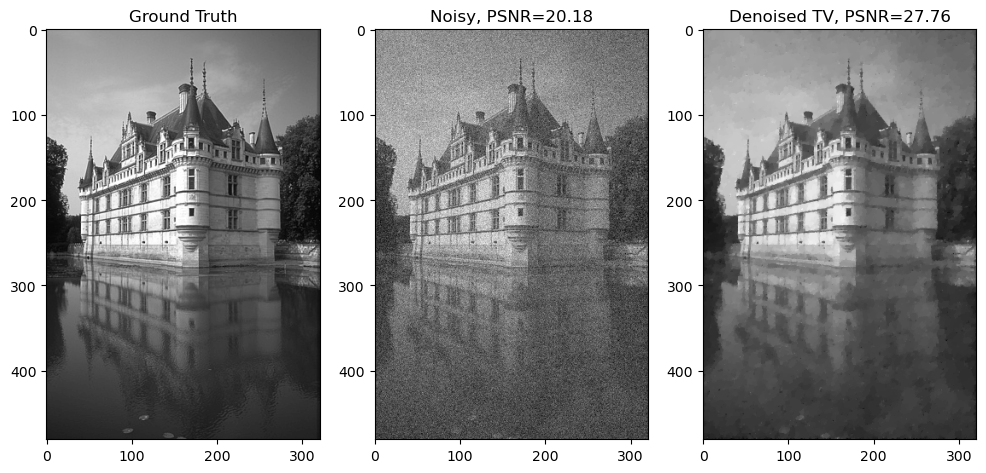

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(x[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Ground Truth')
plt.subplot(132)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Noisy, PSNR=' + str(np.round(psnr_noisy, 2)))
plt.subplot(133)
plt.imshow(denoised_tv[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Denoised TV, PSNR=' + str(np.round(psnr_tv, 2)))
plt.show()

The solve any problem of form 

\begin{equation}
    \text{denoised} = \argmin_{x} \frac{1}{2} \lVert A {x} - y \rVert^2 + \lambda \text{TV}(x)
\end{equation}

you can use the following format with the correct replacement of A and its transpose AT. 

In [9]:
import torch
import torch.nn.functional as F
import math
from tqdm import tqdm
import numpy as np

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define filters (simple finite difference kernel)
filters = torch.Tensor([[[[1., -1.]]]]).to(device).float()

# Forward operator A (convolution)
def A(x):
    # Pad the image to ensure the output size is [481, 321]
    return F.conv2d(F.pad(x, (1, 0, 1, -1)), filters)  # Pad right, left, bottom, and top sides

# Transpose operator AT (transpose convolution with cropping)
def AT(x):
    result = F.conv_transpose2d(x, filters)
    # Crop to match the target shape [481, 321] (same as output of A)
    return result[:, :, :, 1:]  # Remove 1 row from top and 1 column from left

# Set parameters for the algorithm
max_iter = 5000
tol = 1e-6
lmbd = 7.25e-3  # Tuning parameter
tv_iter = 100
res_threshold = 1e-2  # Define a threshold for when `res` stops changing

# Lipschitz constant and step size
alpha = 1 / (torch.linalg.norm(filters)**2)  # Empirical step size

# Load noisy image (example file path)
y = torch.from_numpy(np.load('img_noisy.npy'))[np.newaxis, np.newaxis, :, :].to(device).float()

# Initialize x_init with AT applied to y (ground truth variable)
x_init = AT(y)  # Initialize with A transpose applied to Y
z = AT(y)  # Same initialization for z
t = 1

prox_tv = prox_tv_iso(device)  # Proximal operator for TV

# Iterative optimization loop
with torch.no_grad():
    pbar = tqdm(range(max_iter), dynamic_ncols=True)
    prev_res = float('inf')  # Initialize with a large value
    
    for i in pbar:
        x_old = torch.clone(x_init)
        
        # Compute ATAx
        ATAx = AT(A(x_init))  # Apply A then AT

        # Check for shape mismatch before proceeding
        if ATAx.shape != AT(y).shape:
            raise ValueError(f"Shape mismatch between ATAx and AT(y): {ATAx.shape} vs {AT(y).shape}")
        
        # Update x_init using proximal operator
        x_init = torch.clip(z - alpha * (ATAx - AT(y)), 0., 1.)
        x_init = prox_tv.eval(x_init, tv_iter, lmbd * alpha)

        # Update momentum
        t_old = t
        t = 0.5 * (1 + math.sqrt(1 + 4 * t**2))
        z = x_init + (t_old - 1) / t * (x_init - x_old)

        # Compute relative change (res)
        res = (torch.norm(x_old - x_init) / torch.norm(x_old)).item()
        
        # Check if the relative change is below the threshold (res_threshold)
        if abs(res - prev_res) < res_threshold:
            print(f"Converged early at iteration {i} with res: {res:.2e}")
            break
        
        prev_res = res  # Update the previous res value
        
        # Check for convergence based on the tolerance
        pbar.set_description(f"res: {res:.2e}")
        if res < tol:
            print(f"Converged at iteration {i} with res: {res:.2e}")
            break


# Final denoised image with the correct shape
x_denoised = x_init.detach().cpu()  # This will give [1, 1, 481, 321]
print(x_denoised.shape)  # Should output: torch.Size([1, 1, 481, 321])

res: 3.89e-01:   0%|          | 6/5000 [00:10<2:23:10,  1.72s/it]

Converged early at iteration 6 with res: 3.86e-01
torch.Size([1, 1, 481, 321])


torch.Size([1, 1, 481, 321]) torch.Size([1, 1, 481, 321])


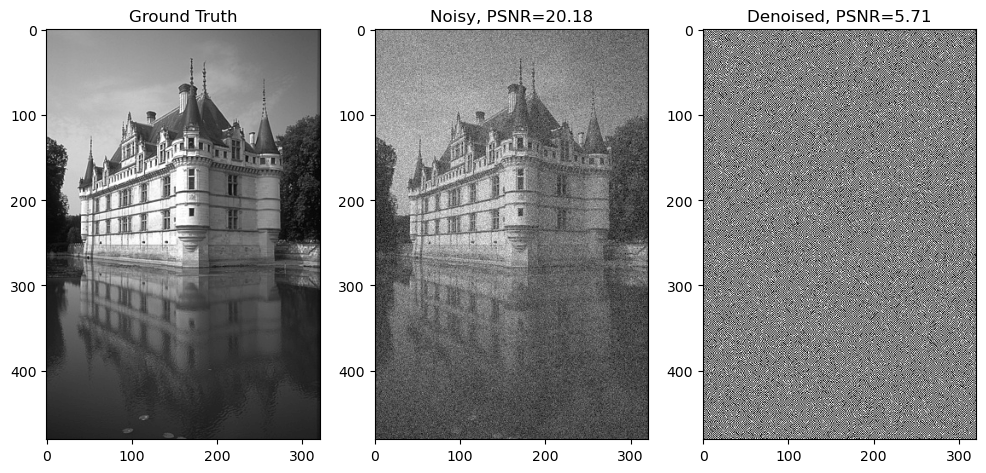

In [13]:
# Print the shape to confirm
print(y.shape, x_denoised.shape)  # Should print torch.Size([481, 321])

# Now you can compute PSNR or proceed with visualization
psnr_noisy = compute_PSNR(x, y)  # x is the ground truth, y is noisy
psnr_denoised = compute_PSNR(x, x_denoised)  # x is the ground truth, denoised image tensor

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(x[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Ground Truth')

plt.subplot(132)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Noisy, PSNR=' + str(np.round(psnr_noisy, 2)))

plt.subplot(133)
plt.imshow(x_denoised[0,0].detach().cpu().numpy(), cmap='gray')  # Make sure to detach for plotting
plt.title('Denoised, PSNR=' + str(np.round(psnr_denoised, 2)))

plt.show()